In [1]:
import sys
import os

#retrieve the absolute path to the 'src' directory

src_patch=os.path.abspath(os.path.join(os.getcwd(), "..", "src"))

#append the path to sys.path to enable module import

sys.path.append(src_patch)

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import f_classif, SelectKBest, RFE, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import shap
from collections import Counter
import warnings
from ML_functions import optimize_f1_threshold, plot_precision_recall_curve, evaluate_model

In [3]:
#load the dataset into memory

df=pd.read_csv("/Users/gabrielemia/Documents/My Project/data/preprocessing_df.csv", index_col=0).drop("customerID", axis=1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#check the classes balance of the target variable

Counter(df["Churn"])

Counter({'No': 5174, 'Yes': 1869})

# <font color="red">Preprocessing</font>

In [5]:
#convert "Senior Citizen" column to appropriate data type

df["SeniorCitizen"]=df["SeniorCitizen"].astype("str")

In [6]:
#impute missing values in the "Total Charges" column

mean= np.mean(df["TotalCharges"])
df["TotalCharges"]=df["TotalCharges"].fillna(mean)

In [7]:
df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
#split the dataset into training and test sets

X_train, X_test, y_train, y_test= train_test_split(df.drop("Churn", axis=1), df["Churn"], test_size=0.3, random_state=0)

In [9]:
#discretize numerical features and encode categorical variables

ct=ColumnTransformer([
    ("discretizer", KBinsDiscretizer(strategy="uniform"), [4, 17, 18]),
     ("encoding", OneHotEncoder(), [0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16])
],
remainder="passthrough")
X_train= ct.fit_transform(X_train)
X_test=ct.transform(X_test)

#retrieve feature names after preprocessing transformations

ar1=ct.named_transformers_["discretizer"].get_feature_names_out()
ar2=ct.named_transformers_["encoding"].get_feature_names_out()
feature_names=np.concatenate((ar1, ar2), axis=0)
bins_range=ct.named_transformers_["discretizer"].bin_edges_

In [10]:
#encode the target variable

le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.transform(y_test)

In [11]:
#select the 10 features most correlated with the target

selector=SelectKBest(chi2, k=10)
X_train=selector.fit_transform(pd.DataFrame(X_train, columns=feature_names), y_train)
X_test=selector.transform(pd.DataFrame(X_test, columns=feature_names))
feature_names=selector.get_feature_names_out()

In [12]:
#apply SMOTE to address the severe class imbalance between Churn = 0 and Churn = 1

resampler=SMOTE(random_state=0)
X_train, y_train=resampler.fit_resample(pd.DataFrame(X_train, columns=feature_names), y_train)
feature_names=resampler.get_feature_names_out()

# <font color="red">Logistic regression

In [13]:
#define a pipeline with Recursive Feature Elimination to retain the top 6 informative features and specify a hyperparameter grid

lr=LogisticRegression(class_weight="balanced", solver="liblinear")
rfe=RFE(lr, n_features_to_select=6, step=2)
pipeline=Pipeline([
    ("rfe", rfe),
    ("lr", lr)
])
param_grid={
    "lr__penalty":["l1", "l2"],
    "lr__C":[x for x in np.arange(0.1, 1, 0.1)]
}

#optimize the model's hyperparameters

optimizer=GridSearchCV(pipeline,
param_grid=param_grid,
error_score="raise",
scoring="f1",
cv=10)

#use the "optimize_f1_threshold" function to train the model with the threshold that maximizes F1-score by balancing precision and recall

best_f1_lr=optimize_f1_threshold(optimizer, pd.DataFrame(X_train, columns=feature_names) , y_train, pd.DataFrame(X_test, columns=feature_names), y_test, 0.1, 1, 0.1)

#extract the actual names of features selected by the model

feature_names_lr=best_f1_lr[2].feature_names_in_

In [14]:
#visualize the best threshold

best_f1_lr[1]

np.float64(0.5)

In [15]:
#visualize the best params

best_f1_lr[2].estimator_.best_params_

{'lr__C': np.float64(0.2), 'lr__penalty': 'l2'}

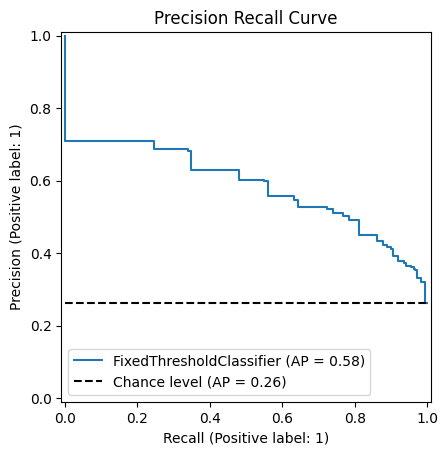

In [16]:
#plot the Precision-Recall curve using the "plot_precision_recall_curve" function

plot_precision_recall_curve(best_f1_lr[2], pd.DataFrame(X_test, columns=feature_names_lr), y_test)

## <font color="green"> Evaluate model

              precision    recall  f1-score   support

           0       0.79      0.72      0.75      3614
           1       0.74      0.80      0.77      3614

    accuracy                           0.76      7228
   macro avg       0.77      0.76      0.76      7228
weighted avg       0.77      0.76      0.76      7228



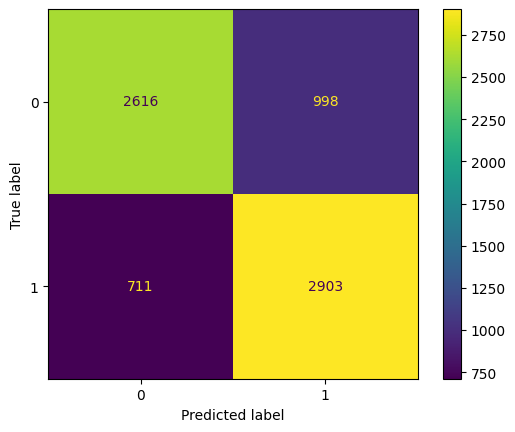

In [17]:
evaluate_model(best_f1_lr[2], pd.DataFrame(X_train, columns=feature_names_lr), y_train, target="classification")

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1560
           1       0.50      0.78      0.61       553

    accuracy                           0.74      2113
   macro avg       0.70      0.75      0.71      2113
weighted avg       0.80      0.74      0.75      2113



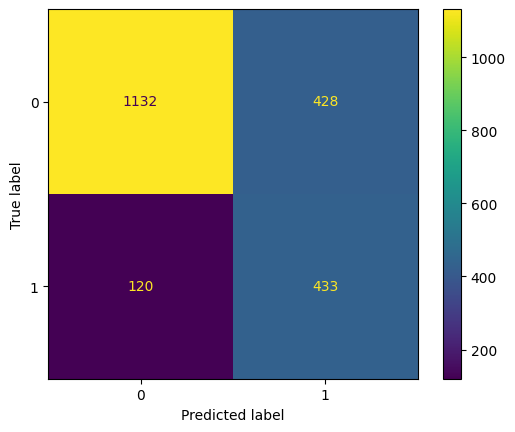

In [18]:
evaluate_model(best_f1_lr[2], pd.DataFrame(X_test, columns=feature_names_lr), y_test, target="classification")

# <font color="red">Decision Tree</font>

In [19]:
#define a pipeline with Recursive Feature Elimination to retain the top 6 informative features and specify a hyperparameter grid

dt=DecisionTreeClassifier(class_weight="balanced")
rfe=RFE(dt, step=2, n_features_to_select=6)
pipeline=Pipeline([
    ("rfe", rfe),
    ("dt", dt)])
param_grid={"dt__criterion":["gini", "entropy"],
            "dt__max_depth":[6,7,8],
            "dt__min_samples_split":[2,3,4],
            "dt__min_samples_leaf":[2,3],
            "dt__max_features":[4,5,6]}

#optimize the model's hyperparameters

optimizer=GridSearchCV(pipeline,
                         param_grid=param_grid, 
                         cv=5, 
                         error_score="raise",
                         scoring="f1")

#use the "optimize_f1_threshold" function to train the model with the threshold that maximizes F1-score by balancing precision and recall

best_f1_dt=optimize_f1_threshold(optimizer, pd.DataFrame(X_train, columns=feature_names) , y_train, pd.DataFrame(X_test, columns=feature_names), y_test, 0.1, 1, 0.1)

#extract the actual names of features selected by the model

feature_names_dt=best_f1_dt[2].feature_names_in_

In [20]:
#visualize the best threshold 

best_f1_dt[1]

np.float64(0.5)

In [21]:
#visualize the best params

best_f1_dt[2].estimator_.best_params_

{'dt__criterion': 'entropy',
 'dt__max_depth': 8,
 'dt__max_features': 6,
 'dt__min_samples_leaf': 2,
 'dt__min_samples_split': 2}

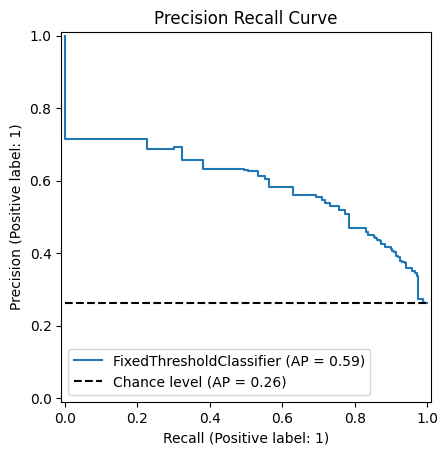

In [22]:
#plot the Precision-Recall curve using the "plot_precision_recall_curve" function

plot_precision_recall_curve(best_f1_dt[2], pd.DataFrame(X_test, columns=feature_names_dt), y_test)

## <font color="green">Evaluate Model

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      3614
           1       0.78      0.80      0.79      3614

    accuracy                           0.78      7228
   macro avg       0.78      0.78      0.78      7228
weighted avg       0.78      0.78      0.78      7228



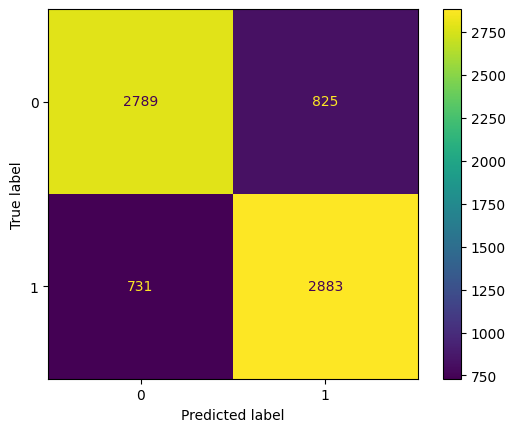

In [23]:
evaluate_model(best_f1_dt[2], pd.DataFrame(X_train, columns=feature_names_lr), y_train, target="classification")

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1560
           1       0.54      0.73      0.62       553

    accuracy                           0.77      2113
   macro avg       0.72      0.75      0.73      2113
weighted avg       0.80      0.77      0.78      2113



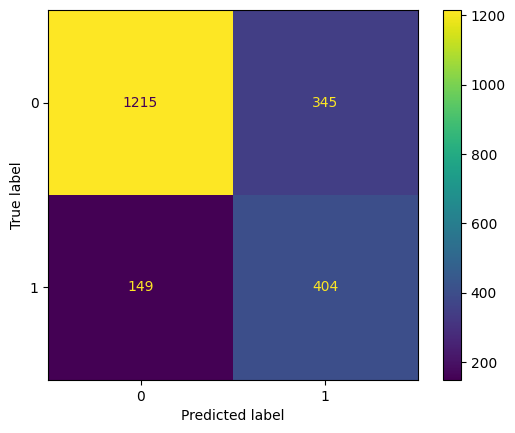

In [24]:
evaluate_model(best_f1_dt[2], pd.DataFrame(X_test, columns=feature_names_dt), y_test, target="classification")

# <font color="red">XGBoost

In [25]:
#define a pipeline with Recursive Feature Elimination to retain the top 6 informative features and specify a hyperparameter grid

xgb=XGBClassifier(scale_pos_weight=0.5)
rfe=RFE(estimator=xgb, step=2, n_features_to_select=6)
pipeline=Pipeline([
    ("rfe", rfe),
    ("xgb", xgb)
])
param_grid={"xgb__n_estimators":[50, 60],
            "xgb__learning_rate":[x for x in np.arange(0.1, 1, 0.1)]}

#optimize the model's hyperparameters

optimizer=GridSearchCV(pipeline,
                         param_grid=param_grid,
                         cv=5, 
                         error_score="raise",
                         scoring="f1")

#use the "optimize_f1_threshold" function to train the model with the threshold that maximizes F1-score by balancing precision and recall

best_f1_xg=optimize_f1_threshold(optimizer,pd.DataFrame(X_train, columns=feature_names) , y_train, pd.DataFrame(X_test, columns=feature_names), y_test, 0.1, 1, 0.1)

#extract the actual names of features selected by the model

feature_names_xg=best_f1_xg[2].feature_names_in_

In [26]:
#visualize the best threshold

best_f1_xg[1]

np.float64(0.5)

In [27]:
#visualize the best params

best_f1_xg[2].estimator_.best_params_

{'xgb__learning_rate': np.float64(0.9), 'xgb__n_estimators': 60}

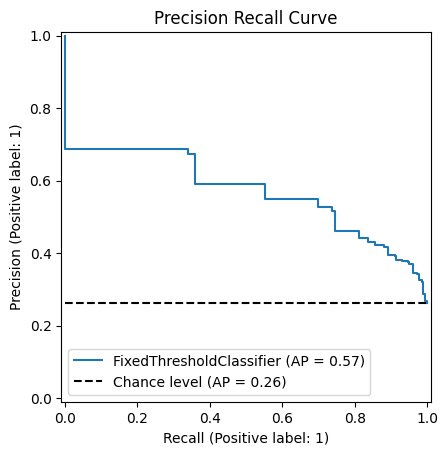

In [28]:
#plot the Precision-Recall curve using the "plot_precision_recall_curve" function

plot_precision_recall_curve(best_f1_xg[2], pd.DataFrame(X_test, columns=feature_names_xg), y_test)

## <font color="green"> Evaluate Model

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      3614
           1       0.79      0.74      0.76      3614

    accuracy                           0.77      7228
   macro avg       0.77      0.77      0.77      7228
weighted avg       0.77      0.77      0.77      7228



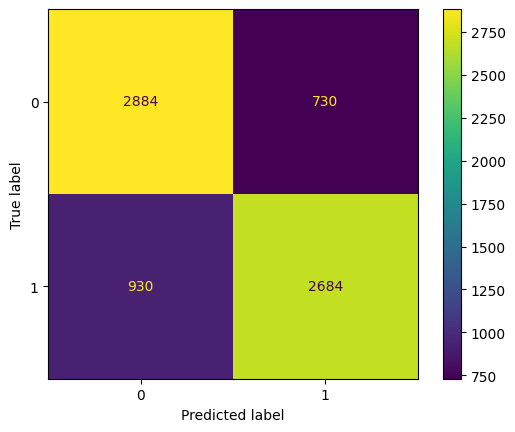

In [29]:
evaluate_model(best_f1_xg[2], pd.DataFrame(X_train, columns=feature_names_lr), y_train, target="classification")

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1560
           1       0.55      0.70      0.62       553

    accuracy                           0.77      2113
   macro avg       0.72      0.75      0.73      2113
weighted avg       0.80      0.77      0.78      2113



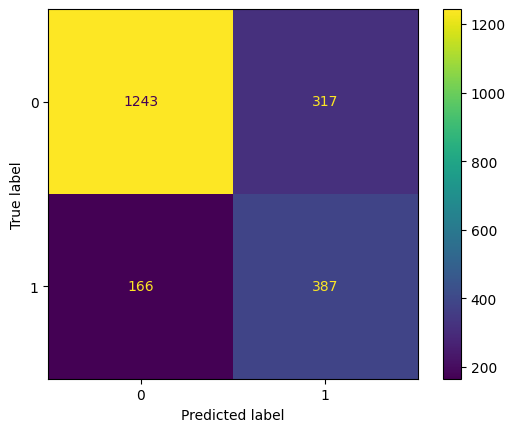

In [30]:
evaluate_model(best_f1_xg[2], pd.DataFrame(X_test, columns=feature_names_xg), y_test, target="classification")

# <font color="red"> Random Forest

In [31]:
rf=RandomForestClassifier(random_state=0)
rfe=RFE(rf, n_features_to_select=6, step=2)
pipeline=Pipeline([
    ("rfe", rfe),
    ("rf", rf)
])
param_grid={"rf__n_estimators":[20, 30],
            "rf__max_depth":[3,4],
            "rf__min_samples_split":[2,3]}

optimizer=GridSearchCV(pipeline,
param_grid=param_grid,
error_score="raise",
scoring="f1")

best_f1_rf=optimize_f1_threshold(optimizer,pd.DataFrame(X_train, columns=feature_names) , y_train, pd.DataFrame(X_test, columns=feature_names), y_test, 0.1, 1, 0.1)

feature_names_rf=best_f1_rf[2].feature_names_in_

In [32]:
#visualize the best threshold

best_f1_rf[1]

np.float64(0.6)

In [33]:
#visualize the best params

best_f1_rf[2].estimator_.best_params_

{'rf__max_depth': 3, 'rf__min_samples_split': 2, 'rf__n_estimators': 20}

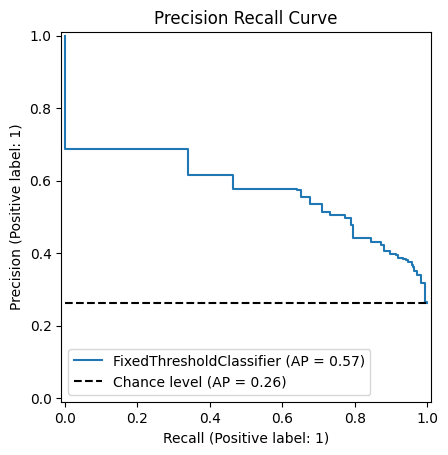

In [34]:
#plot the Precision-Recall curve using the "plot_precision_recall_curve" function

plot_precision_recall_curve(best_f1_rf[2], pd.DataFrame(X_test, columns=feature_names_rf), y_test)

## <font color="green"> Evaluate model

              precision    recall  f1-score   support

           0       0.74      0.79      0.76      3614
           1       0.77      0.72      0.75      3614

    accuracy                           0.76      7228
   macro avg       0.76      0.76      0.76      7228
weighted avg       0.76      0.76      0.76      7228



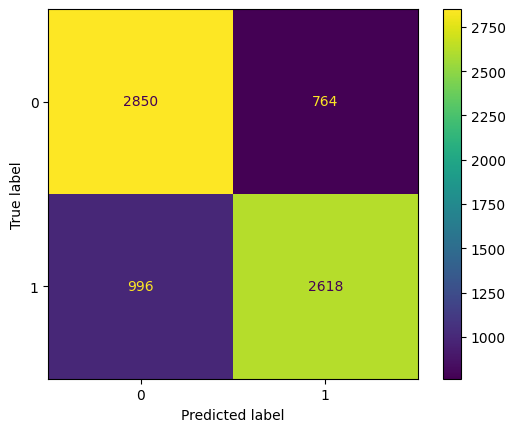

In [35]:
evaluate_model(best_f1_rf[2], pd.DataFrame(X_train, columns=feature_names_lr), y_train, target="classification")

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1560
           1       0.54      0.70      0.61       553

    accuracy                           0.76      2113
   macro avg       0.71      0.74      0.72      2113
weighted avg       0.79      0.76      0.77      2113



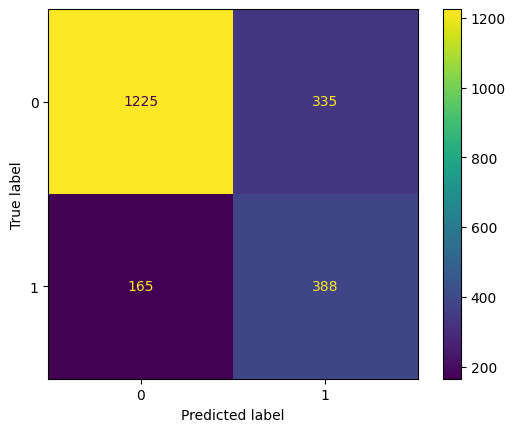

In [36]:
evaluate_model(best_f1_rf[2], pd.DataFrame(X_test, columns=feature_names_rf), y_test, target="classification")

# <font color="red">Importanza delle variabili per il modello 

In [39]:
#ignore warnings

warnings.filterwarnings("ignore")

In [40]:
#compute SHAP values for each feature by processing the dataset in batches due to its size

data= shap.sample(X_train, 10)
explainer=shap.KernelExplainer(best_f1_lr[2].predict, data)
shap_values=explainer.shap_values(X_test)

  0%|          | 0/2113 [00:00<?, ?it/s]

100%|██████████| 2113/2113 [01:10<00:00, 29.79it/s]


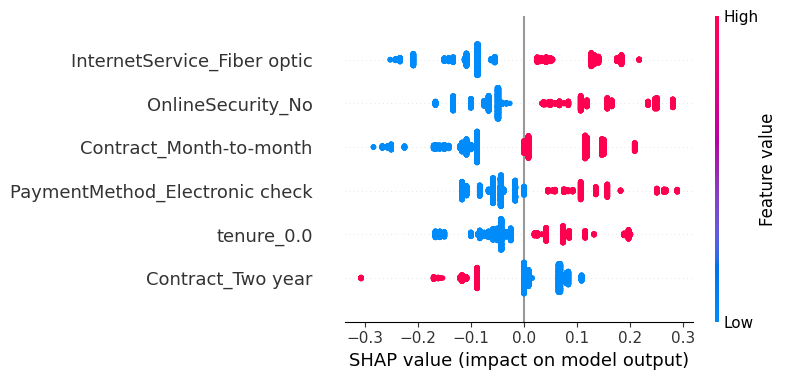

In [41]:
#visualize the top 6 informative features selected by the model

shap.summary_plot(shap_values, pd.DataFrame(X_test, columns=feature_names_xg), max_display=6)

In [42]:
#display the bin intervals used to discretize the "tenure" variable

bins_range[0]

array([ 0. , 14.4, 28.8, 43.2, 57.6, 72. ])

# <font color="red"> Conclusions

L'obiettivo del progetto è sviluppare un modello in grado di predire efficientemente il Churn da parte di un cliente.</br>
La sfida principale è rappresentata dallo sbilanciamento della variabile target "Churn", un fenomeno tipico di questa tipologia di dataset, in quanto un fornitore di servizi, per poter mantenere l'impresa, vuole fidelizzare i propri clienti, mentre i casi di disdetta rimangono in minoranza.</br>
Per gestire questo squilibrio, in fase di preprocessing dei dati, sono stati generati dati sintetici(SMOTE) sul dataset di training, utili a bilanciare il divario tra le due classi e permettere al modello di apprendere anche la classe positiva(Churn). Di seguito le operazioni di preprocessing che sono state effettuate:<ol>
<li>imputazione dei valori mancanti per la variabile "Total Charges";</li>
<li>discretizzazione delle variabili numeriche, essendo esse in netta minoranza;</li>
<li>encoding delle variabili categoriche;</li>
<li>encoding della variabile target;</li>
<li>selezione delle 10 features maggiormente correlate con il target, basandosi sul test del chi-quadro;</li>
<li>oversampling del dataset di training tramite l'approccio SMOTE, al fine di equilibrare la distribuzione (inizialmente 5174 vs 1879)</li></ol></br>
Successivamente si è proceduto alla fase di scelta del modello da applicare: inizialmente sono stati tentati modelli più semplici, come regressione logistica e alberi decisionali, per poi passare a modelli più complessi basati su Boosting e Bagging. 
I modelli sono stati addestrati dopo una fase di Recursive Feature Elimination e ottimizzazione degli iperparametri tramite GridSearchCV. </br>
Infine è seguito l'addestramento vero e proprio all'interno di una funzione personalizzata, la quale, scorrendo una lista di soglie decisionali, esegue l'addestramento con il valore che restituisce il miglior bilanciamento tra precision e recall (F1 score), in quanto, data la natura del problema, si è preferito sovrastimare il churn piuttosto che sottostimarlo.
Il comportamento osservato è stato coerente con i modelli: ottima precision sulla classe negativa, discrete le recall su entrambe le classi, ma la precision della classe positiva è molto bassa (50%). Nonostante l'oversampling, il divario informativo intrinseco tra le due classi, non riesce comunque ad essere colmato.</br>
 </br></br>
Infine, l'analisi degli SHAP values ha confermato quanto già emerso dall'analisi esplorativa: <ul> 
<li>i contratti con durata mensile aumentano la probabilità di churn, mentre i contratti di durata biennale la riducono; </li>
<li>la fibra ottica presenta delle criticità, in quanto, a livelli alti di sottoscrizioni, contribuisce ad aumentare la probabilità di Churn, mentre la sicurezza online, agli stessi livelli diminuisce la probabilità di disdetta. Questo potrebbe essere dovuto a delle criticità relative al rapporto qualità/prezzo: dalla fibra ottica ci si aspettano prestazioni di rilievo e possiede un costo più elevato rispetto alla DSL, quindi un possibile malcontento dei clienti potrebbe essere causato da una differenza prestazionale troppo lieve tra i due prodotti, che non giustifica il divario di prezzo;</li>
<li>la permanenza del cliente con il fornitore gioca un ruolo importante, in quanto più è bassa, più il tasso di Churn è elevato.</li></ul></br></br>
È evidente che il problema maggiore risieda nella fidelizzazione dei nuovi clienti. Investire in apposite strategie volte alla trasformazione di contratti brevi in impegni a lungo termine potrebbe rivelarsi la soluzione più efficace.